<h1>
    Q.1 Modeling 
</h1>

<h3>Skill:</h3>
<ul>
    <li>Player 1 skill: $s_1$</li>
    <li>Player 2 skill: $s_2$</li>
</ul>
Where: $s_1 \sim \mathcal{N}(\mu_1,\,\sigma^{2}_1)$

Where: $s_2 \sim \mathcal{N}(\mu_2,\,\sigma^{2}_2)$

<h3>Game outcome:</h3>
<ul>
    <li>$t = s_1 - s_2$</li>
</ul>
Where: $t \sim \mathcal{N}(\mu_t = s_1 - s_2,\,\sigma^{2}_t)$

<h3>Game result:</h3>
<ul>
    <li>If player 1 wins: $y = 1$</li>
    <li>If player 2 wins: $y = -1$</li>
</ul>

<h3>Bayesian model:</h3>
<ul>
    <li>$P(s_1, s_2, t, y) = P(y|t) \cdot P(t|s_1, s_2) \cdot P(s_1) \cdot P(s_2)$</li>
</ul>
Where: 
<ul>
    <li>$P(y|t)$ Game result given game outcome</li>
    <li>$P(t|s_1, s_2)$ Game outcome given player skills</li>
    <li>$P(s_1)$ and $P(s_2)$ Player skill priors</li>
</ul>

<h3>Hyperparameters:</h3>
<ul>
    <li>Player 1: $\mu_1$ and $\sigma^{2}_1$</li>
    <li>Player 2: $\mu_2$ and $\sigma^{2}_2$</li>
    <li>Unpredictability of the game outcome: $\sigma^{2}_t$</li>
</ul>

<h1>
    Q.2 Bayesian Network
</h1>

$s_1$ and $s_2$ influences $t$ 

$t$ then influences $y$

<h1>
    Q.3 Computing with the model
</h1>

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm

<h3>Initialization</h3>

<h3>$p(s1, s2|t, y)$ - Full conditional distribution of the skills</h3>

In [2]:
# Gaussian-Gaussian Bayesian Update
def update_skills(s1_mean, s1_var, s2_mean, s2_var, t_var, t_samples):
    A = np.array([[1, -1]])
    mu_prior = np.array([[s1_mean], [s2_mean]])
    sigma_prior = np.array([[s1_var, 0], [0, s2_var]])
        
    sigma_posterior = np.linalg.inv(np.linalg.inv(sigma_prior) + (t_var)**(-1) * (A.T @ A))
    mu_posterior = sigma_posterior @ (np.linalg.inv(sigma_prior) @ mu_prior + t_var**(-1) * A.T * t_samples)

    return mu_posterior, sigma_posterior

mean_s1 = 1
var_s1 =  1
mean_s2 = -1
var_s2 = 4
var_t = 5
t_obs = 3

mu_posterior, Sigma_posterior = update_skills(mean_s1,var_s1,mean_s2,var_s2,var_t,t_obs)
print("Posterior mean of s1 and s2:", mu_posterior)
print("Posterior covariance of s1 and s2:", Sigma_posterior)

Posterior mean of s1 and s2: [[ 1.1]
 [-1.4]]
Posterior covariance of s1 and s2: [[0.9 0.4]
 [0.4 2.4]]


# <h3>$p(t|s1, s2, y)$ - Full conditional distribution of the outcome</h3>

In [3]:
def conditional_distribution_t(s1, s2, y):
    t_mean = s1 - s2
    a, b = 0, 0
    
    if y == 1:
        a = 0
        b = np.inf
    else:
        a = -np.inf
        b = 0
    return t_mean, a, b

s1 = 2
s2 = 1
t_var = 5
y = 1

mu, a, b = conditional_distribution_t(s1, s2, y)

print(f"Parameters for p(t|s1, s2, y):\nmu_t: {mu}, sigma^2: {round(t_var,4)} \nBounds: [{a}, {b}]")

Parameters for p(t|s1, s2, y):
mu_t: 1, sigma^2: 5 
Bounds: [0, inf]


<h3>$p(y=1)$ - Marginal probability that Player 1 wins the game</h3>

In [4]:
# Marginal Probability that Player 1 Wins
def compute_marginal_probability(mu_t, var_s1, var_s2, var_t):
    sigma_t = np.sqrt(var_s1 + var_s2 + var_t)
    probability_y1 = 1 - norm.cdf(0, mu_t, sigma_t)
    
    return probability_y1

var_s1 =  1
var_s2 =  4
mu_t = 2
t_var = 5

prob_y1 = compute_marginal_probability(mu_t, var_s1, var_s2, t_var)
print(f"Marginal probability that Player 1 wins (p(y=1)): {round(prob_y1,4)}")
print(f"Marginal probability that Player 2 wins (p(y=-1)): {round(1-prob_y1,4)}")


Marginal probability that Player 1 wins (p(y=1)): 0.7365
Marginal probability that Player 2 wins (p(y=-1)): 0.2635


<h1>
    Q.4  A first Gibbs sampler
</h1>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm

def gibbs_sampling_trueskill(N, N_burn_in, match_properties):
    s1_mean = match_properties["s1_mean"]
    s1_var = match_properties["s1_var"]
    s1_std = np.sqrt(s1_var)
    
    s2_mean = match_properties["s2_mean"]
    s2_var = match_properties["s2_var"]
    s2_std = np.sqrt(s2_var)
    
    y = match_properties["y"]

    
    t_var = s1_var + s2_var
    
    s1_samples, s2_samples, t_samples = np.zeros(N), np.zeros(N), np.zeros(N)
    s1_samples[0] = (np.random.normal(s1_mean, s1_std))
    s2_samples[0] = (np.random.normal(s2_mean, s2_std))
    
    for i in range(N - 1):
        t_mean = s1_samples[i] - s2_samples[i]
        t_mean, a, b = conditional_distribution_t(s1_samples[i], s2_samples[i], y)
        t_samples[i] = truncnorm.rvs(a = a, b = b, loc=t_mean, scale=np.sqrt(t_var))
    
        mu_posterior, sigma_posterior = update_skills(s1_mean, s1_var, s2_mean, s2_var, t_var, t_samples[i]) 
    
        s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T
    
    return np.array(s1_samples[N_burn_in:]), np.array(s2_samples[N_burn_in:]), np.array(t_samples[N_burn_in:])

s1_mean = 1
s1_var = 1
s2_mean = 1
s2_var = 1
y = 1

match_properties = {
    "s1_mean": s1_mean,
    "s1_var": s1_var,
    "s2_mean": s2_mean,
    "s2_var": s2_var,
    "y": y
}


N = 10000
N_burn_in = int((N**0.5)/2)

s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)

C:\Users\claud\AppData\Local\Temp\ipykernel_27812\2023761384.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


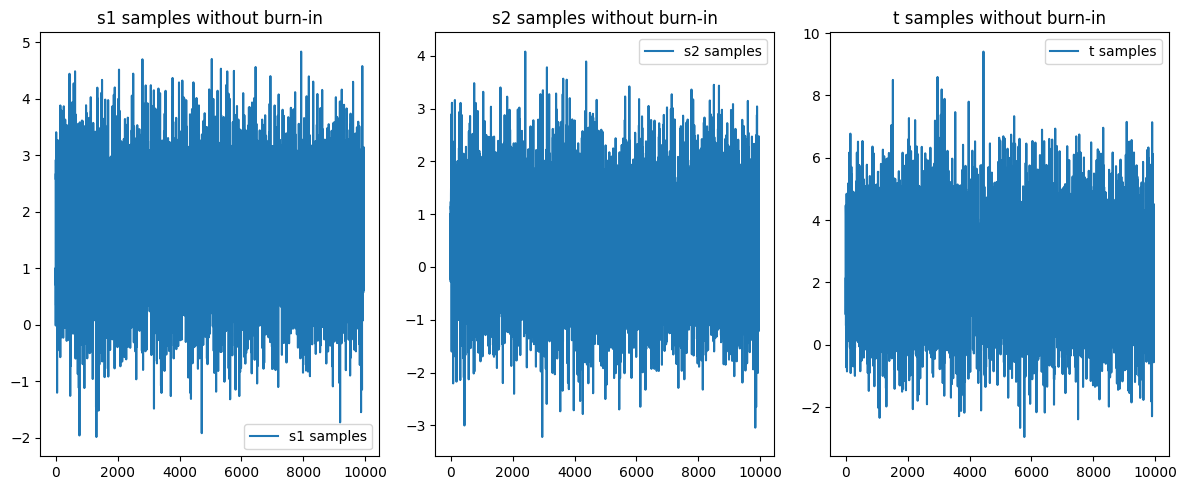

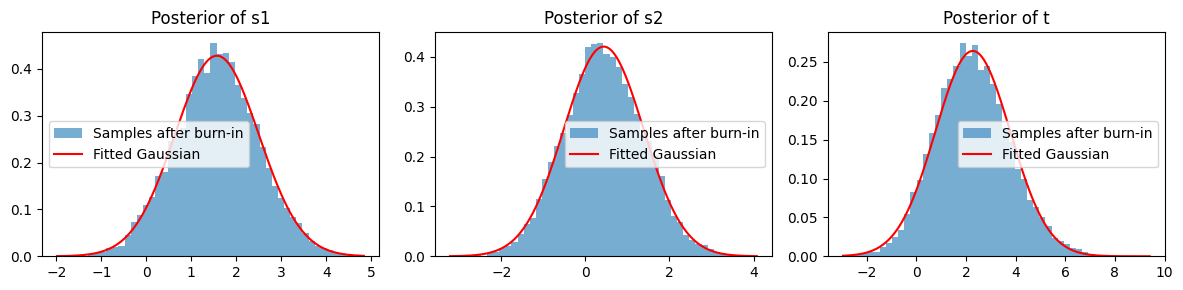

In [8]:
def plot_samples(s1_samples, s2_samples, t_samples):
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].plot(s1_samples, label="s1 samples")
    ax[0].set_title("s1 samples without burn-in")
    ax[0].legend()
    
    ax[1].plot(s2_samples, label="s2 samples")
    ax[1].set_title("s2 samples without burn-in")
    ax[1].legend()

    ax[2].plot(t_samples, label="t samples")
    ax[2].set_title("t samples without burn-in")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()

def plot_histogram_with_fitted_gaussian(samples, title, ax):
    mu = np.mean(samples)
    sigma = np.std(samples)
    ax.hist(samples, bins=50, density=True, alpha=0.6, label="Samples after burn-in")
    ax.plot(np.linspace(min(samples), max(samples), 400), 
            norm.pdf(np.linspace(min(samples), max(samples), 400), mu, sigma), 
            'r', label="Fitted Gaussian")
    ax.legend()
    ax.set_title(title)

plot_samples(s1_samples, s2_samples, t_samples)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
plot_histogram_with_fitted_gaussian(s1_samples, "Posterior of s1", ax[0])
plot_histogram_with_fitted_gaussian(s2_samples, "Posterior of s2", ax[1])
plot_histogram_with_fitted_gaussian(t_samples, "Posterior of t", ax[2])
plt.tight_layout()
plt.show()

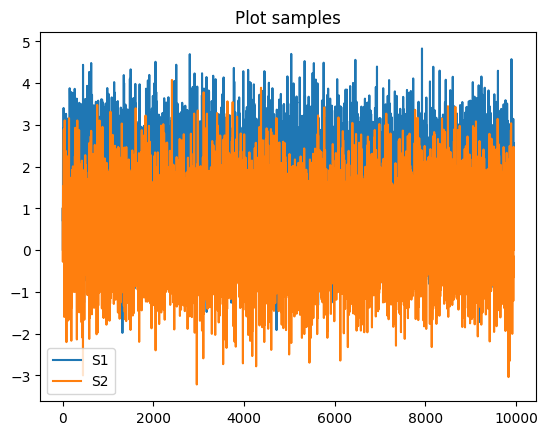

In [9]:
plt.plot(s1_samples, label="S1")
plt.plot(s2_samples, label="S2")
plt.title("Plot samples")
plt.legend()
plt.show()

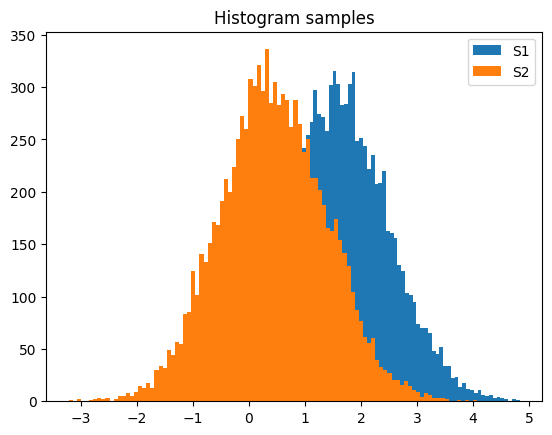

In [10]:
plt.hist(s1_samples, bins = int(N**0.5), label="S1")
plt.hist(s2_samples, bins = int(N**0.5), label="S2")
plt.title("Histogram samples")
plt.legend()
plt.show()

<h1>
    Q.5  Assumed Density Filtering
</h1>

In [13]:
import pandas as pd

seriea_df = pd.read_csv('SerieA.csv')

# Extract all unique teams
teams = list(set(seriea_df['team1'].unique()) | set(seriea_df['team2'].unique()))

# Initialize each team's skills with a common prior
initial_mean = 25
initial_variance = 8.33

team_skills = {team: {'mean': initial_mean, 'variance': initial_variance} for team in teams}
team_skills


{'Fiorentina': {'mean': 25, 'variance': 8.33},
 'Frosinone': {'mean': 25, 'variance': 8.33},
 'Inter': {'mean': 25, 'variance': 8.33},
 'Bologna': {'mean': 25, 'variance': 8.33},
 'Milan': {'mean': 25, 'variance': 8.33},
 'Spal': {'mean': 25, 'variance': 8.33},
 'Sassuolo': {'mean': 25, 'variance': 8.33},
 'Torino': {'mean': 25, 'variance': 8.33},
 'Cagliari': {'mean': 25, 'variance': 8.33},
 'Roma': {'mean': 25, 'variance': 8.33},
 'Genoa': {'mean': 25, 'variance': 8.33},
 'Atalanta': {'mean': 25, 'variance': 8.33},
 'Parma': {'mean': 25, 'variance': 8.33},
 'Napoli': {'mean': 25, 'variance': 8.33},
 'Sampdoria': {'mean': 25, 'variance': 8.33},
 'Chievo': {'mean': 25, 'variance': 8.33},
 'Udinese': {'mean': 25, 'variance': 8.33},
 'Juventus': {'mean': 25, 'variance': 8.33},
 'Empoli': {'mean': 25, 'variance': 8.33},
 'Lazio': {'mean': 25, 'variance': 8.33}}

In [16]:
N = 100
N_burn_in = int((N**0.5)/2)

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']
    
    # Skip the match if it's a draw
    if score1 == score2:
        continue
        
    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Sort teams by their final skill means to get the ranking
sorted_teams = sorted(team_skills.items(), key=lambda x: x[1]['mean'], reverse=True)

ranked_teams = [(team[0], team[1]['mean']) for team in sorted_teams]
ranked_teams

C:\Users\claud\AppData\Local\Temp\ipykernel_27812\2023761384.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


[('Juventus', 48.274830576236106),
 ('Napoli', 42.74943026989384),
 ('Roma', 30.907484753554552),
 ('Inter', 29.7691694869844),
 ('Milan', 29.12162344723115),
 ('Torino', 28.240775108691867),
 ('Sassuolo', 28.186290840558932),
 ('Fiorentina', 28.060863838306304),
 ('Sampdoria', 26.38903699543759),
 ('Genoa', 25.293328512419947),
 ('Atalanta', 24.98693973447521),
 ('Lazio', 24.537894489976786),
 ('Spal', 21.99603817997077),
 ('Udinese', 21.60918454774431),
 ('Parma', 19.021233094934004),
 ('Empoli', 17.398898800731747),
 ('Cagliari', 17.32656851078052),
 ('Bologna', 13.622327958352717),
 ('Frosinone', 6.753331931167866),
 ('Chievo', 5.612869360389516)]

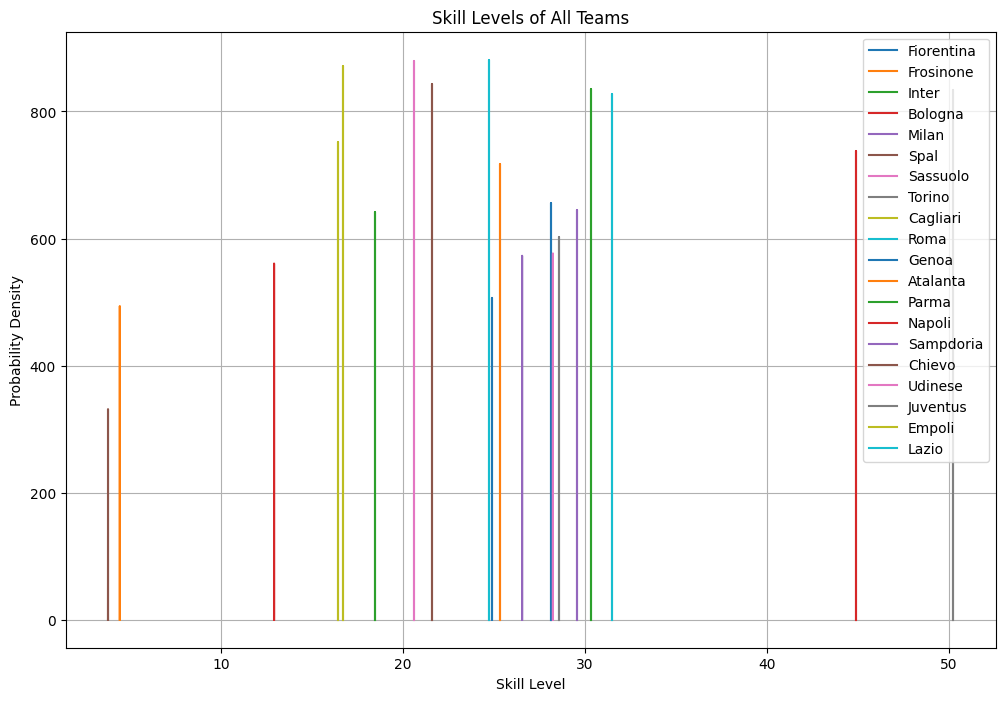

In [29]:
plt.figure(figsize=(12, 8))

for team in team_skills.keys():
    mean = team_skills[team]['mean']
    std_dev = np.sqrt(team_skills[team]['variance'])
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    plt.plot(x, norm.pdf(x, mean, std_dev), label=team)

plt.title('Skill Levels of All Teams')
plt.xlabel('Skill Level')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

<h1>
    Q.6 Using the model for predictions
</h1>

In [25]:
# Prediction function
def predict_winner(s1_mean, s1_var, s2_mean, s2_var):
    diff_mean = s1_mean - s2_mean
    diff_var = s1_var + s2_var
    # Compute the probability that Player 1's skill is greater than Player 2's skill
    return 1 if compute_marginal_probability(diff_mean, s1_var, s2_var, diff_var) > 0.5 else -1

correct_predictions = 0
total_predictions = 0

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']

    # Skip the match if it's a draw
    if score1 == score2:
        continue

    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Predict the winner based on current skill estimates
    prediction = predict_winner(
        team_skills[team1]['mean'], team_skills[team1]['variance'],
        team_skills[team2]['mean'], team_skills[team2]['variance']
    )
    
    # Compare prediction to actual result
    if prediction == y:
        correct_predictions += 1

    total_predictions += 1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Compute prediction rate
prediction_rate = correct_predictions / total_predictions

prediction_rate

C:\Users\claud\AppData\Local\Temp\ipykernel_27812\2023761384.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


0.7389705882352942